## Project Title:  Environmental Sentiment Analysis of Social Media Discourse

Objective: To analyze sentiment trends related to environmental issues discussed on social media platforms, 
providing insights into public perceptions and attitudes towards environmental issues.

### Import  and download needed libraries

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import nltk

In [ ]:
pip install praw # for extraction of post from reddit data

In [ ]:
#pip install preprocess_kgptalkie # 

In [ ]:
pip install vaderSentiment # for sentiment analysis

In [ ]:
pip install NRCLex # for emotion analysis

 ### Scraping data from reddit

In [ ]:
import pandas as pd
from datetime import datetime
import time
import praw
from prawcore.exceptions import TooManyRequests, NotFound

# Reddit API credentials
client_id = '993RzwxCcu-yvYFYJPZIcw'
client_secret = 'LkB9mkZJq_cYKw-vOHXOyT489rFSaQ'
user_agent = 'sentiment analysis by /u/No-Parsnip5503'

# Initialize PRAW
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

# Define search keywords and subreddits
keywords = [
    "climate", "global warming", "environment", "nature", "pollution", 
    "plastic", "green energy", "food waste", "water waste", "greenhouse", 
    "recycling", "air quality", "eco-friendly", "emission", "renewable energy", 
    "sustainable", "zero waste", "carbon dioxide", "ecology", "smog", 
    "biodiversity"
]
subreddits = [
    "climate", "global warming", "environment", "nature", "pollution", 
    "plastic", "green energy", "food waste", "water waste", "greenhouse", 
    "recycling", "air quality", "eco-friendly", "emission", "renewable energy", 
    "sustainable", "zero waste", "carbon dioxide", "ecology", "smog", 
    "biodiversity"

]

start_year = 2013
end_year = 2023

# Initialize a list to store the posts
posts = []

def get_posts_by_month(keyword, subreddit, year, month):
    query = f'title:{keyword}'
    start_epoch = int(datetime(year, month, 1).timestamp())
    end_epoch = int(datetime(year, month, 28 if month == 2 else 30).timestamp())  # Adjust for month-end

    return reddit.subreddit(subreddit).search(
        query, sort='new', time_filter='all', syntax='cloudsearch', limit=100,
        params={'after': start_epoch, 'before': end_epoch}
    )

for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        for keyword in keywords:
            for subreddit in subreddits:
                try:
                    submissions = get_posts_by_month(keyword, subreddit, year, month)
                    for submission in submissions:
                        # Skip calculation if upvote_ratio is exactly 0.5 to avoid division by zero
                        if submission.upvote_ratio == 0.5:
                            upvotes = None
                            downvotes = None
                        else:
                            # Calculate upvotes and downvotes
                            upvotes = submission.score * submission.upvote_ratio / (submission.upvote_ratio - 0.5)
                            downvotes = upvotes - submission.score
                        posts.append({
                            'title': submission.title,
                            'selftext': submission.selftext,
                            'created_utc': submission.created_utc,
                            'subreddit': submission.subreddit.display_name,
                            'url': submission.url,
                            'score': submission.score,
                            'upvotes': round(upvotes) if upvotes is not None else None,
                            'downvotes': round(downvotes) if downvotes is not None else None,
                            'num_comments': submission.num_comments,
                            'keyword': keyword
                        })
                    time.sleep(1)  # Respect Reddit's rate limit
                except TooManyRequests as e:
                    print(f"Rate limit exceeded: {e}. Sleeping for 10 minutes.")
                    time.sleep(600)  # Sleep for 10 minutes
                except NotFound as e:
                    print(f"Subreddit or submission not found: {e}")
                except Exception as e:
                    print(f"An error occurred: {e}")
                    time.sleep(5)  # Wait before retrying

# Convert the list of posts into a DataFrame
df = pd.DataFrame(posts)

# Save the DataFrame to a CSV file
df.to_csv('environmental_reddit_posts.csv', index=False)

print(f"Total posts collected: {len(df)}")


### Load and explore scraped data

In [5]:
df = pd.read_csv(r"C:\Users\DELL\Downloads\environmental_reddit_posts1.csv") # upload the data

In [6]:
df

,title,selftext,created_utc,subreddit,url,score,upvotes,downvotes,num_comments,keyword
0,Exxon faces shareholder uprising over climate ...,NaN,1.716304e+09,climate,https://www.eenews.net/articles/exxon-faces-sh...,5,10.0,5.0,0,climate
1,EU's Green Deal improved its climate performan...,NaN,1.716299e+09,climate,https://climateactiontracker.org/blog/eus-gree...,2,6.0,4.0,1,climate
2,Climate victims file criminal case against bos...,NaN,1.716297e+09,climate,https://www.theguardian.com/environment/articl...,7,16.0,9.0,1,climate
3,Climate victims file criminal case against bos...,NaN,1.716293e+09,climate,https://www.theguardian.com/environment/articl...,14,28.0,14.0,0,climate
4,Top oil firms’ climate pledges failing on almo...,Capitalism is killing us,1.716293e+09,climate,https://www.theguardian.com/us-news/article/20...,70,143.0,73.0,9,climate
...,...,...,...,...,...,...,...,...,...,...
589111,'Reality Check': Report Shows 'Staggering' Fai...,NaN,1.526755e+09,nature,https://www.commondreams.org/news/2018/05/18/r...,92,190.0,98.0,0,biodiversity
589112,Cerrado: abandoned pasturelands fail to regain...,NaN,1.524289e+09,nature,https://news.mongabay.com/2018/04/cerrado-aban...,61,125.0,64.0,2,biodiversity
589113,Oil palm plantations’ dearth of biodiversity r...,NaN,1.521463e+09,nature,https://news.mongabay.com/2018/03/oil-palm-pla...,12,26.0,14.0,0,biodiversity
589114,Paradise Under Pressure: The fences protecting...,NaN,1.518534e+09,nature,http://www.biographic.com/posts/sto/paradise-u...,9,20.0,11.0,1,biodiversity


In [7]:
df.columns # columns in the datafrrame

Index(['title', 'selftext', 'created_utc', 'subreddit', 'url', 'score',
       'upvotes', 'downvotes', 'num_comments', 'keyword'],
      dtype='object')

In [8]:
df.shape # number of rows and columns

(589116, 10)

In [9]:
#convert date to date tme

# Ensure 'created_utc' is a datetime object
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s', errors='coerce')

# Extract the year create a new column
df['year'] = df['created_utc'].dt.year

# Extract the month and create a new column
df['month'] = df['created_utc'].dt.month

In [10]:
df['year'].value_counts() # NUM OF POST BY YEAR

2023    210287
2024    145570
2022     82291
2021     40788
2020     30360
2019     21516
2018     16236
2017     15180
2016      8052
2015      5768
2014      3168
2010      3036
2011      2508
2013      1716
2012      1716
2008       660
2009       264
Name: year, dtype: int64

In [11]:
df['month'].value_counts() # NUM OF POST BY MONTH

5     77936
4     62882
3     53648
11    52001
1     49764
2     49368
12    48708
6     41844
9     41268
10    40656
8     36061
7     34980
Name: month, dtype: int64

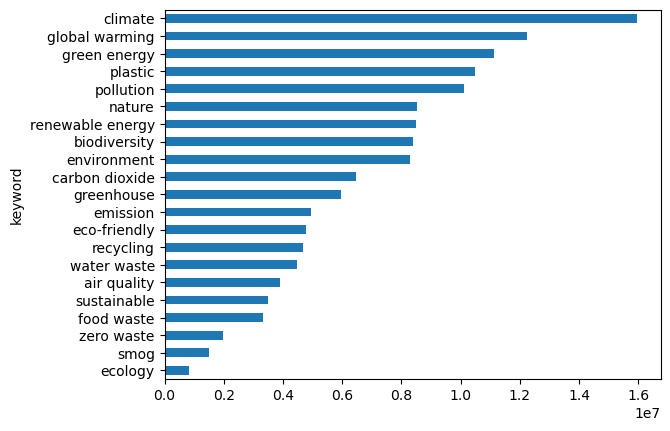

In [47]:
# popular keywords by the number of upvotes

import pandas as pd
import matplotlib.pyplot as plt

# Group by 'keyword' and sum the 'upvotes'
grouped_data = df.groupby('keyword')['upvotes'].sum()

# Sort the summed upvotes in ascending order
sorted_grouped_data = grouped_data.sort_values(ascending=True)

# Plot the sorted data as a bar chart
sorted_grouped_data.plot(kind='barh')

# Show the plot
plt.show()


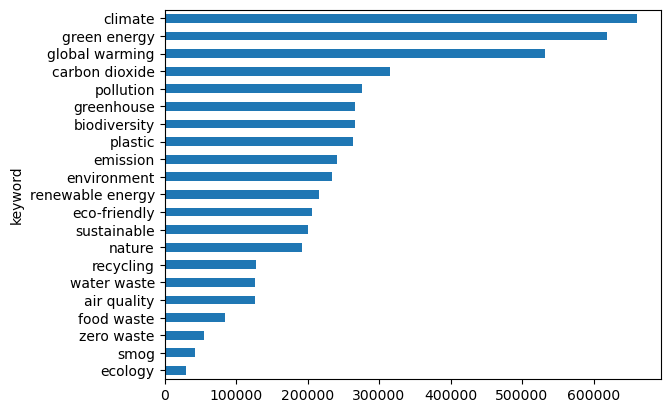

In [46]:
# # popular keywords by the number of num_cooments

import pandas as pd
import matplotlib.pyplot as plt

# Group by 'keyword' and sum the 'upvotes'
grouped_data = df.groupby('keyword')['num_comments'].sum()

# Sort the summed upvotes in ascending order
sorted_grouped_data = grouped_data.sort_values(ascending=True)

# Plot the sorted data as a bar chart
sorted_grouped_data.plot(kind='barh')

# Show the plot
plt.show()


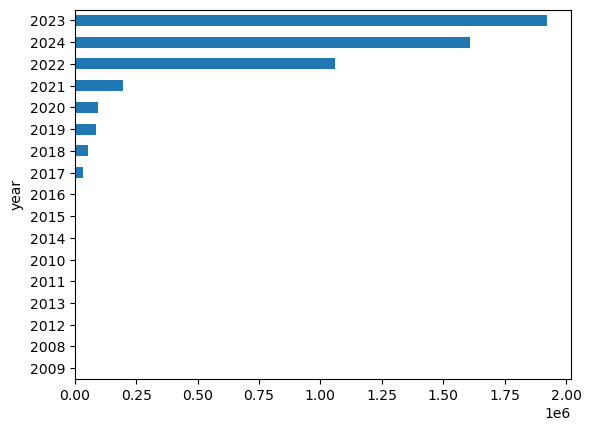

In [74]:
# #  num_cooments by year

import pandas as pd
import matplotlib.pyplot as plt

# Group by 'keyword' and sum the 'upvotes'
grouped_data = df.groupby('year')['num_comments'].sum()

# Sort the summed upvotes in ascending order
sorted_grouped_data = grouped_data.sort_values(ascending=True)

# Plot the sorted data as a bar chart
sorted_grouped_data.plot(kind='barh')

# Show the plot
plt.show()

In [13]:
# distribution of environmental post per year

In [14]:
import pandas as pd

# Define your list of environmental keywords
environmental_keywords = [
    "water pollution", "soil erosion", "deforestation", "habitat destruction",
    "acidification", "marine conservation", "ocean pollution",
    "wildlife protection", "sustainable development", "green technology",
    "renewable resources", "clean water", "clean air", "carbon offset",
    "carbon neutral", "carbon footprint", "carbon sequestration",
    "renewable fuel", "solar power", "wind energy", "hydropower",
    "geothermal energy", "tidal energy", "wave energy", "nuclear energy",
    "electric vehicles", "energy efficiency", "carbon trading", "sustainable agriculture",
    "organic farming", "agroforestry", "permaculture", "green building",
    "urban planning", "bicycle infrastructure", "public transportation",
    "renewable energy subsidies", "green jobs", "renewable energy investment",
    "climate resilience", "natural disaster prevention", "renewable energy policy",
    "carbon tax", "sustainable tourism", "eco-tourism", "green chemistry",
    "waste reduction", "waste recycling", "composting", "biodegradable",
    "reusable", "renewable energy incentives", "green bonds", "carbon markets",
     "climate", "global warming", "environment", "nature", "pollution",
    "plastic", "green energy", "food waste", "water waste", "greenhouse",
    "recycling", "air quality", "eco-friendly", "emission",
    "renewable energy", "sustainable", "zero waste", "carbon dioxide",
    "ecology", "smog",'biodiversity','pollution','co2',"climate", "global warming", "environment", "nature",
    "pollution", "plastic", "green energy", "food waste", "water waste", "greenhouse", "recycling", 
    "air quality", "eco-friendly", "emission", "renewable energy", "sustainable", 
    "zero waste", "carbon dioxide", "ecology", "smog", "biodiversity"
]

# Filter the DataFrame to include only posts related to environmental topics
environmental_posts = df[df['keyword'].str.lower().isin(environmental_keywords)]

# Extract the year from the 'created_utc' column
environmental_posts['year'] = pd.to_datetime(environmental_posts['created_utc']).dt.year

# Group the data by year and count the number of posts in each year
posts_per_year = environmental_posts.groupby('year').size()

# Print or visualize the number of environmental posts per year
print(posts_per_year)


year
2008       660
2009       264
2010      3036
2011      2508
2012      1716
2013      1716
2014      3168
2015      5768
2016      8052
2017     15180
2018     16236
2019     21516
2020     30360
2021     40788
2022     82291
2023    210287
2024    145570
dtype: int64


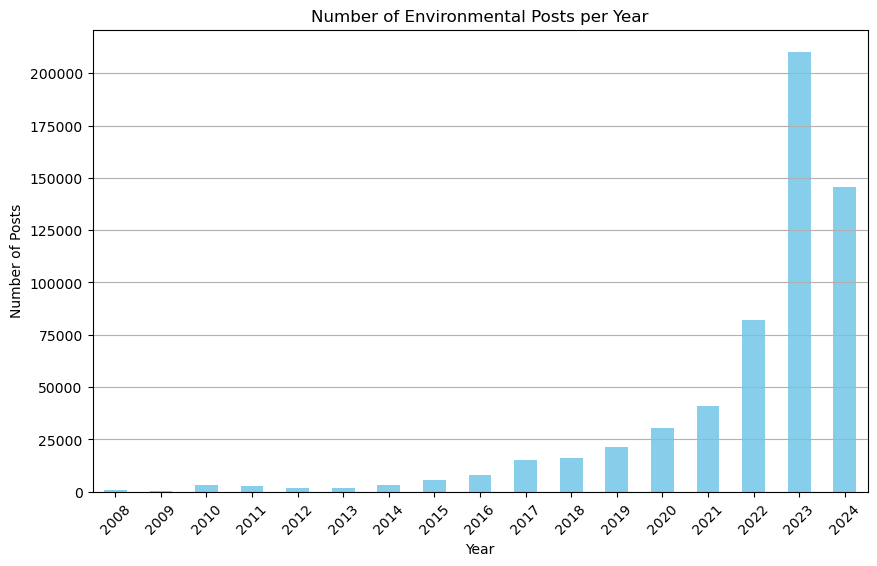

In [16]:
# viualisation of environmental post per year

import matplotlib.pyplot as plt

# Plot a bar chart showing the number of environmental posts per year
plt.figure(figsize=(10, 6))
posts_per_year.plot(kind='bar', color='skyblue')
plt.title('Number of Environmental Posts per Year')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


### Data preprocessing

In [25]:
df.isnull().sum() # number of missing values 

title                0
selftext        568870
created_utc          0
subreddit            0
url                  0
score                0
upvotes           6717
downvotes         6717
num_comments         0
keyword              0
year                 0
month                0
dtype: int64

In [17]:
df2 = df.copy() # copy of main data fram

In [18]:
df2 = df2.dropna() # drop null values

In [21]:
df2

,title,selftext,created_utc,subreddit,url,score,upvotes,downvotes,num_comments,keyword,year,month
4,Top oil firms’ climate pledges failing on almo...,Capitalism is killing us,2024-05-21 11:59:32,climate,https://www.theguardian.com/us-news/article/20...,70,143.0,73.0,9,climate,2024,5
32,"Help: Americans trust Climate Change is real, ...","Hello,\n\nI’m seeking the results of a poll th...",2024-05-18 16:20:36,climate,https://anytimeestimate.com/research/climate-c...,57,127.0,70.0,12,climate,2024,5
38,Cop29 at a crossroads in Azerbaijan with focus...,"It's all about the money, not the future of li...",2024-05-18 09:14:54,climate,https://www.theguardian.com/world/article/2024...,4,12.0,8.0,2,climate,2024,5
55,Chairman Whitehouse Opens Budget Hearing on Cl...,"May 15 | Senator Sheldon Whitehouse (D-RI), Ch...",2024-05-16 18:52:13,climate,https://youtu.be/3OSgaQ4CGws?si=28DY9hoPPZRCHEUk,11,24.0,13.0,0,climate,2024,5
58,Activists sue Russia over ‘weak’ climate polic...,More of this sort of thing,2024-05-16 17:49:41,climate,https://www.theguardian.com/environment/articl...,33,74.0,41.0,3,climate,2024,5
...,...,...,...,...,...,...,...,...,...,...,...,...
588835,Trophic Rewilding of Nature can Capture Vast A...,Natural Climate Solutions (Nature Based Climat...,2023-05-04 02:11:21,climate,https://youtu.be/46MijWkRmp8,9,20.0,11.0,0,biodiversity,2023,5
588859,Nexus Dicey Board Game On Climate Change and B...,Stay tuned for [\#Nexus](https://www.linkedin....,2022-05-02 17:54:28,climate,https://www.reddit.com/r/climate/comments/ugvg...,2,4.0,2.0,0,biodiversity,2022,5
588865,Mercury human health threats and biodiversity ...,"\n\n**VANCOUVER, BRITISH COLUMBIA, CANADA, Oc...",2021-10-22 01:14:23,climate,https://www.reddit.com/r/climate/comments/qd61...,3,6.0,3.0,0,biodiversity,2021,10
589092,A unique island bird data strengthens biodiver...,Data belongs to birds in thousands of islands ...,2020-02-20 06:39:11,nature,https://www.reddit.com/r/nature/comments/f6p2t...,2,6.0,4.0,0,biodiversity,2020,2


In [ ]:
# text cleaning 

In [23]:
# This code involves Removal of URLs, onversion to lowercase, Removal of special characters and hashtags etc. 

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

port_stem = PorterStemmer()

def preprocess_content(content):
    # Remove URLs
    content = re.sub(r'http\S+|www\S+|https\S+', '', content, flags=re.MULTILINE)
    
    # Remove special characters and hashtags
    content = re.sub(r'\@\w+|\#', '', content)
    content = re.sub(r'[^A-Za-z0-9\s]', '', content)
    
    # Convert to lowercase
    content = content.lower()
    
    # Tokenize
    words = content.split()
    
    # Remove stopwords and apply stemming
    processed_words = [port_stem.stem(word) for word in words if word not in stopwords.words('english')]
    
    # Join words back into a single string
    processed_content = ' '.join(processed_words)
    
    return processed_content

# Apply stemming to the 'selftext' column and create a new column 'stemmed_content'
df2['stemmed_content'] = df2['selftext'].apply(preprocess_content)

In [24]:
df2

,title,selftext,created_utc,subreddit,url,score,upvotes,downvotes,num_comments,keyword,year,month,stemmed_content
4,Top oil firms’ climate pledges failing on almo...,Capitalism is killing us,2024-05-21 11:59:32,climate,https://www.theguardian.com/us-news/article/20...,70,143.0,73.0,9,climate,2024,5,capit kill us
32,"Help: Americans trust Climate Change is real, ...","Hello,\n\nI’m seeking the results of a poll th...",2024-05-18 16:20:36,climate,https://anytimeestimate.com/research/climate-c...,57,127.0,70.0,12,climate,2024,5,hello im seek result poll read coupl year ago ...
38,Cop29 at a crossroads in Azerbaijan with focus...,"It's all about the money, not the future of li...",2024-05-18 09:14:54,climate,https://www.theguardian.com/world/article/2024...,4,12.0,8.0,2,climate,2024,5,money futur life earth
55,Chairman Whitehouse Opens Budget Hearing on Cl...,"May 15 | Senator Sheldon Whitehouse (D-RI), Ch...",2024-05-16 18:52:13,climate,https://youtu.be/3OSgaQ4CGws?si=28DY9hoPPZRCHEUk,11,24.0,13.0,0,climate,2024,5,may 15 senat sheldon whitehous dri chairman us...
58,Activists sue Russia over ‘weak’ climate polic...,More of this sort of thing,2024-05-16 17:49:41,climate,https://www.theguardian.com/environment/articl...,33,74.0,41.0,3,climate,2024,5,sort thing
...,...,...,...,...,...,...,...,...,...,...,...,...,...
588835,Trophic Rewilding of Nature can Capture Vast A...,Natural Climate Solutions (Nature Based Climat...,2023-05-04 02:11:21,climate,https://youtu.be/46MijWkRmp8,9,20.0,11.0,0,biodiversity,2023,5,natur climat solut natur base climat solut cos...
588859,Nexus Dicey Board Game On Climate Change and B...,Stay tuned for [\#Nexus](https://www.linkedin....,2022-05-02 17:54:28,climate,https://www.reddit.com/r/climate/comments/ugvg...,2,4.0,2.0,0,biodiversity,2022,5,stay tune nexu dicey upcom environment awar bo...
588865,Mercury human health threats and biodiversity ...,"\n\n**VANCOUVER, BRITISH COLUMBIA, CANADA, Oc...",2021-10-22 01:14:23,climate,https://www.reddit.com/r/climate/comments/qd61...,3,6.0,3.0,0,biodiversity,2021,10,vancouv british columbia canada octob 17 2021 ...
589092,A unique island bird data strengthens biodiver...,Data belongs to birds in thousands of islands ...,2020-02-20 06:39:11,nature,https://www.reddit.com/r/nature/comments/f6p2t...,2,6.0,4.0,0,biodiversity,2020,2,data belong bird thousand island aegean sea


### Sentiment analysis

In [31]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def classify_sentiment(text):
    # Apply sentiment analysis
    sentiment_scores = analyzer.polarity_scores(text)
    # Classify as positive, negative, or neutral based on compound score
    compound_score = sentiment_scores['compound']
    if compound_score > 0.00:
        return 'positive'
    elif compound_score < 0.00:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis to each row in the DataFrame
df2['sentiment'] = df2['selftext'].apply(classify_sentiment)



In [109]:
df2

,title,selftext,created_utc,subreddit,url,score,upvotes,downvotes,num_comments,keyword,year,month,stemmed_content,sentiment
4,Top oil firms’ climate pledges failing on almo...,Capitalism is killing us,2024-05-21 11:59:32,climate,https://www.theguardian.com/us-news/article/20...,70,143.0,73.0,9,climate,2024,5,capit kill us,negative
32,"Help: Americans trust Climate Change is real, ...","Hello,\n\nI’m seeking the results of a poll th...",2024-05-18 16:20:36,climate,https://anytimeestimate.com/research/climate-c...,57,127.0,70.0,12,climate,2024,5,"hello, i’m seek result poll read coupl year ag...",positive
38,Cop29 at a crossroads in Azerbaijan with focus...,"It's all about the money, not the future of li...",2024-05-18 09:14:54,climate,https://www.theguardian.com/world/article/2024...,4,12.0,8.0,2,climate,2024,5,"money, futur life earth",neutral
55,Chairman Whitehouse Opens Budget Hearing on Cl...,"May 15 | Senator Sheldon Whitehouse (D-RI), Ch...",2024-05-16 18:52:13,climate,https://youtu.be/3OSgaQ4CGws?si=28DY9hoPPZRCHEUk,11,24.0,13.0,0,climate,2024,5,"may 15 | senat sheldon whitehous (d-ri), chair...",negative
58,Activists sue Russia over ‘weak’ climate polic...,More of this sort of thing,2024-05-16 17:49:41,climate,https://www.theguardian.com/environment/articl...,33,74.0,41.0,3,climate,2024,5,sort thing,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588835,Trophic Rewilding of Nature can Capture Vast A...,Natural Climate Solutions (Nature Based Climat...,2023-05-04 02:11:21,climate,https://youtu.be/46MijWkRmp8,9,20.0,11.0,0,biodiversity,2023,5,natur climat solut (natur base climat solution...,positive
588859,Nexus Dicey Board Game On Climate Change and B...,Stay tuned for [\#Nexus](https://www.linkedin....,2022-05-02 17:54:28,climate,https://www.reddit.com/r/climate/comments/ugvg...,2,4.0,2.0,0,biodiversity,2022,5,stay tune [\#nexus](https://www.linkedin.com/f...,neutral
588865,Mercury human health threats and biodiversity ...,"\n\n**VANCOUVER, BRITISH COLUMBIA, CANADA, Oc...",2021-10-22 01:14:23,climate,https://www.reddit.com/r/climate/comments/qd61...,3,6.0,3.0,0,biodiversity,2021,10,"**vancouver, british columbia, canada, octob 1...",negative
589092,A unique island bird data strengthens biodiver...,Data belongs to birds in thousands of islands ...,2020-02-20 06:39:11,nature,https://www.reddit.com/r/nature/comments/f6p2t...,2,6.0,4.0,0,biodiversity,2020,2,data belong bird thousand island aegean sea. [...,neutral


In [ ]:
# piechart of sentiment category

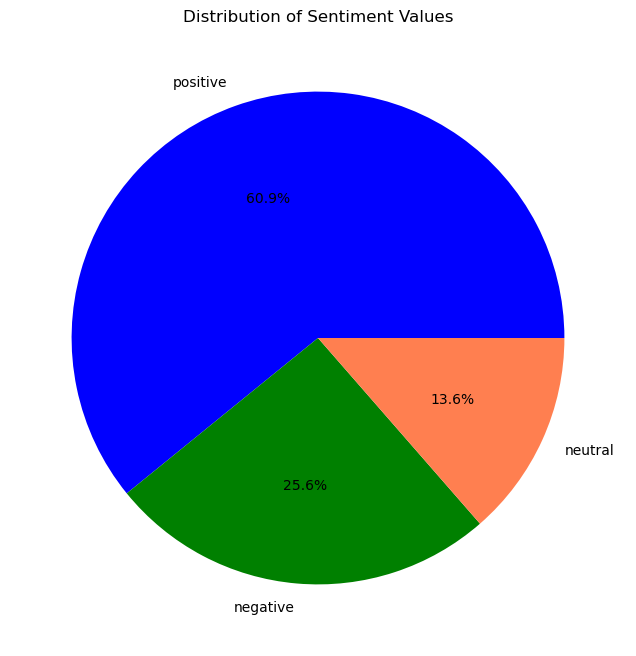

In [85]:
import matplotlib.pyplot as plt

# Count the frequency of each sentiment value
sentiment_counts = df2['sentiment'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['blue', 'green', 'coral'])
plt.title('Distribution of Sentiment Values')
plt.ylabel('')
plt.show()


In [49]:
df2['stemmed_content'].iloc[3]

'may 15 senat sheldon whitehous dri chairman us senat budget committe deliv follow open statement budget committe hear titl budget storm climat chang cost nation secur hear examin strain loom climat crisi place defens nation secur oper infrastructur'

In [50]:
df2['selftext'].iloc[3]

'May 15 | Senator Sheldon Whitehouse (D-RI), Chairman of the U.S. Senate Budget Committee, delivered the following opening statement at a Budget Committee hearing, titled “Budgeting for the Storm: Climate Change and the Costs to National Security.”\n\nThe hearing examined the strain that the looming climate crisis is placing on our defense and national security operations and infrastructure.'

In [51]:
df2['sentiment'].iloc[3]

'negative'

In [52]:
# Count the number of positive, negative, and neutral comments per year

sentiment_counts = df2.groupby(['year', 'sentiment']).size().unstack(fill_value=0)

# Print the sentiment counts for verification
print(sentiment_counts)


sentiment  negative  neutral  positive
year                                  
2013              0        0       132
2017            264      132       792
2018            264      132      1320
2019            514        0      1188
2020           1584      264      1584
2021           1306      264      2640
2022              0      924       792
2023            264      396      1452
2024            660      469      1664


<Figure size 1200x600 with 0 Axes>

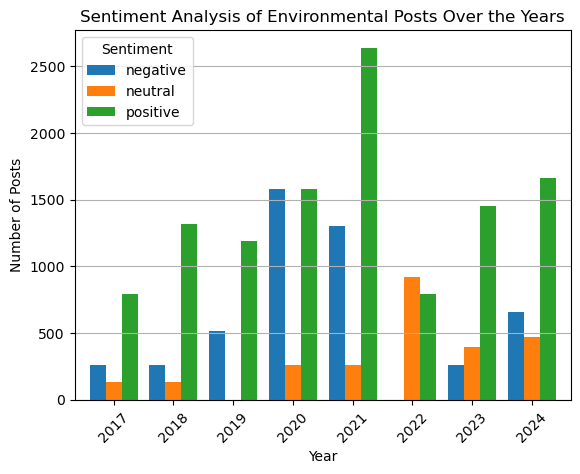

In [53]:
# visualistaion of count of sentiment category over the years

import matplotlib.pyplot as plt


# Exclude the year 2013 from the plot
sentiment_counts_filtered = sentiment_counts[sentiment_counts.index != 2013]

# Plot the sentiment trends over the years with side-by-side bars
plt.figure(figsize=(12, 6))
sentiment_counts_filtered.plot(kind='bar', width=0.8)
plt.title('Sentiment Analysis of Environmental Posts Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Sentiment', loc='upper left')
plt.grid(axis='y')
plt.show()


### Popular environmental keyword

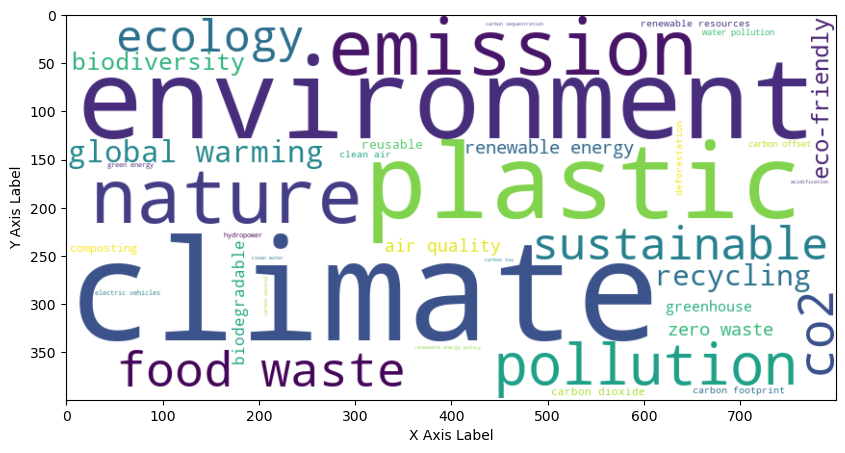

In [56]:
# word cloud visualisation

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import TextBlob
import re


# Keywords related to environmental issues
keywords = [
   "water pollution", "soil erosion", "deforestation", "habitat destruction",
    "acidification", "marine conservation", "ocean pollution",
    "wildlife protection", "sustainable development", "green technology",
    "renewable resources", "clean water", "clean air", "carbon offset",
    "carbon neutral", "carbon footprint", "carbon sequestration",
    "renewable fuel", "solar power", "wind energy", "hydropower",
    "geothermal energy", "tidal energy", "wave energy", "nuclear energy",
    "electric vehicles", "energy efficiency", "carbon trading", "sustainable agriculture",
    "organic farming", "agroforestry", "permaculture", "green building",
    "urban planning", "bicycle infrastructure", "public transportation",
    "renewable energy subsidies", "green jobs", "renewable energy investment",
    "climate resilience", "natural disaster prevention", "renewable energy policy",
    "carbon tax", "sustainable tourism", "eco-tourism", "green chemistry",
    "waste reduction", "waste recycling", "composting", "biodegradable",
    "reusable", "renewable energy incentives", "green bonds", "carbon markets",
     "climate", "global warming", "environment", "nature", "pollution",
    "plastic", "green energy", "food waste", "water waste", "greenhouse",
    "recycling", "air quality", "eco-friendly", "emission",
    "renewable energy", "sustainable", "zero waste", "carbon dioxide",
    "ecology", "smog",'biodiversity','pollution','co2',"climate", "global warming", "environment", "nature",
    "pollution", "plastic", "green energy", "food waste", "water waste", "greenhouse", "recycling", 
    "air quality", "eco-friendly", "emission", "renewable energy", "sustainable", 
    "zero waste", "carbon dioxide", "ecology", "smog", "biodiversity"
    
]



# Filter tweets containing relevant keywords
environmental_tweets = df2[df2['selftext'].str.contains('|'.join(keywords), case=False)]

# Count occurrences of environmental issue keywords
issue_counts = {}
for keyword in keywords:
    issue_counts[keyword] = environmental_tweets['selftext'].str.count(keyword, flags=re.IGNORECASE).sum()

# Generate a WordCloud of environmental issue keywords
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(issue_counts)

# Display the WordCloud with axis labels and numbers
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.xlabel('X Axis Label')
plt.ylabel('Y Axis Label')
plt.show()


In [ ]:
# barchart visualisation

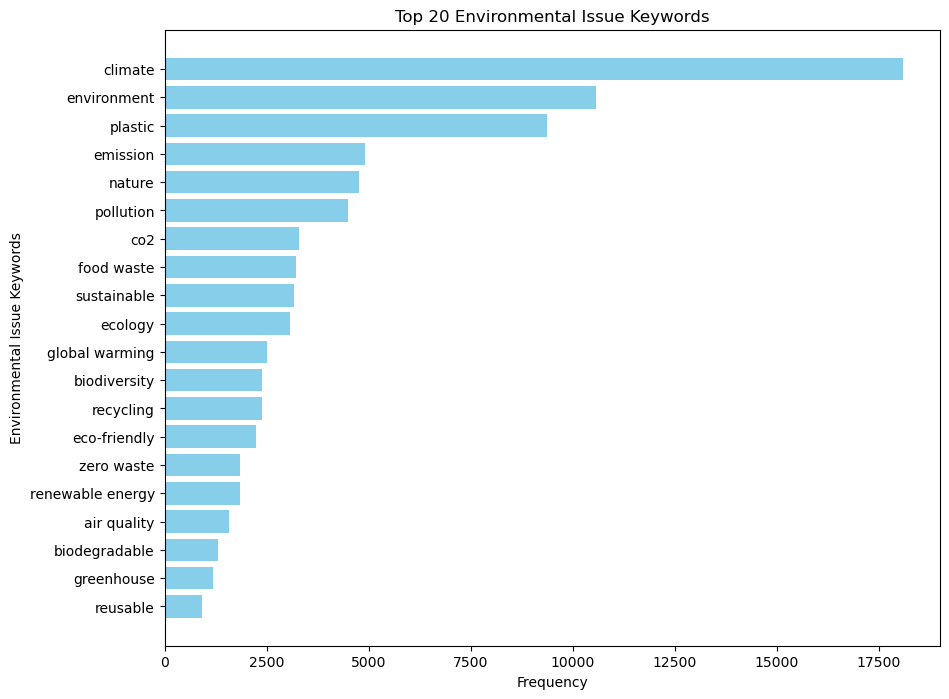

In [57]:


# Convert issue_counts dictionary to a DataFrame and sort by frequency
issue_counts_df = pd.DataFrame(issue_counts.items(), columns=['Keyword', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Take top 10 keywords
top_10_keywords = issue_counts_df.head(20)

# Plot horizontal bar chart for top 20 keywords
plt.figure(figsize=(10, 8))
plt.barh(top_10_keywords['Keyword'], top_10_keywords['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Environmental Issue Keywords')
plt.title('Top 20 Environmental Issue Keywords')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()


### Emotion analysis

In [58]:
# Filter for negative comments
negative_comments = df2[df2['sentiment'] == 'negative']

In [59]:
negative_comments

,title,selftext,created_utc,subreddit,url,score,upvotes,downvotes,num_comments,keyword,year,month,stemmed_content,sentiment
4,Top oil firms’ climate pledges failing on almo...,Capitalism is killing us,2024-05-21 11:59:32,climate,https://www.theguardian.com/us-news/article/20...,70,143.0,73.0,9,climate,2024,5,capit kill us,negative
55,Chairman Whitehouse Opens Budget Hearing on Cl...,"May 15 | Senator Sheldon Whitehouse (D-RI), Ch...",2024-05-16 18:52:13,climate,https://youtu.be/3OSgaQ4CGws?si=28DY9hoPPZRCHEUk,11,24.0,13.0,0,climate,2024,5,may 15 senat sheldon whitehous dri chairman us...,negative
311,My new video… Global Tipping Points Status: Ne...,"While COP28 occurred in Dubai, UAE near the en...",2024-04-12 03:07:45,climate,https://youtu.be/8L6_lddx87o?si=vecZmhDppTX159yX,3,6.0,3.0,1,global warming,2024,4,cop28 occur dubai uae near end last year landm...,negative
370,Global warming in the pipeline- James Hansen. ...,Global warming in the pipeline- James Hansen\n...,2023-12-28 00:24:27,climate,https://academic.oup.com/oocc/article/3/1/kgad...,135,285.0,150.0,76,global warming,2023,12,global warm pipelin jame hansen pass peer revi...,negative
627,"‘In a word, horrific’: Trump’s extreme anti-en...","I have no words for this man, the people who b...",2024-02-06 22:00:24,climate,https://www.theguardian.com/us-news/2024/feb/0...,148,302.0,154.0,9,environment,2024,2,word man peopl back peopl vote cant even decid...,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588613,The Ecology of War and Energy,**Rated G:** for general audiences\n\nPower is...,2019-07-26 11:31:15,environment,https://www.reddit.com/r/environment/comments/...,4,12.0,8.0,1,ecology,2019,7,rate g gener audienc power word mean understan...,negative
588627,Climate Ecocide and Ecology of The Collapse Mind,I made a post about age and climate ecocide. D...,2018-10-15 10:16:18,environment,https://www.reddit.com/r/environment/comments/...,1,2.0,1.0,0,ecology,2018,10,made post age climat ecocid go well post 1 rco...,negative
588650,Was the USA an ecology leader in the late 60's...,America did not ratify the Kyoto protocol. I b...,2017-03-17 21:32:10,environment,https://www.reddit.com/r/environment/comments/...,1,6.0,5.0,0,ecology,2017,3,america ratifi kyoto protocol believ australia...,negative
588656,Me and my friend are doing a Gallup for a scho...,The question is: \nWhat are the most crucial...,2020-08-20 09:29:35,nature,https://www.reddit.com/r/nature/comments/id74l...,1,6.0,5.0,1,ecology,2020,8,question crucial ecolog problem current world ...,negative


In [60]:
# classification of emotion

from nrclex import NRCLex

# Function to get emotions from text
def get_emotions(text):
    emotion = NRCLex(text)
    emotion_scores = emotion.raw_emotion_scores
    # Filter for the emotions we are interested in
    filtered_emotions = {k: v for k, v in emotion_scores.items() if k in ['fear', 'anger', 'anticipation', 'trust', 'surprise', 'sadness', 'disgust', 'joy']}
    return filtered_emotions

# Apply emotion analysis to negative comments
negative_comments['emotions'] = negative_comments['stemmed_content'].apply(get_emotions)

# Print the DataFrame with emotions
#print(negative_comments[['stemmed_content', 'emotions']])


C:\Users\DELL\AppData\Local\Temp\ipykernel_22304\3388427043.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_comments['emotions'] = negative_comments['stemmed_content'].apply(get_emotions)


In [61]:
negative_comments

,title,selftext,created_utc,subreddit,url,score,upvotes,downvotes,num_comments,keyword,year,month,stemmed_content,sentiment,emotions
4,Top oil firms’ climate pledges failing on almo...,Capitalism is killing us,2024-05-21 11:59:32,climate,https://www.theguardian.com/us-news/article/20...,70,143.0,73.0,9,climate,2024,5,capit kill us,negative,"{'fear': 1, 'sadness': 1}"
55,Chairman Whitehouse Opens Budget Hearing on Cl...,"May 15 | Senator Sheldon Whitehouse (D-RI), Ch...",2024-05-16 18:52:13,climate,https://youtu.be/3OSgaQ4CGws?si=28DY9hoPPZRCHEUk,11,24.0,13.0,0,climate,2024,5,may 15 senat sheldon whitehous dri chairman us...,negative,"{'trust': 7, 'anger': 1, 'anticipation': 1, 'f..."
311,My new video… Global Tipping Points Status: Ne...,"While COP28 occurred in Dubai, UAE near the en...",2024-04-12 03:07:45,climate,https://youtu.be/8L6_lddx87o?si=vecZmhDppTX159yX,3,6.0,3.0,1,global warming,2024,4,cop28 occur dubai uae near end last year landm...,negative,"{'trust': 25, 'anticipation': 15, 'joy': 4, 's..."
370,Global warming in the pipeline- James Hansen. ...,Global warming in the pipeline- James Hansen\n...,2023-12-28 00:24:27,climate,https://academic.oup.com/oocc/article/3/1/kgad...,135,285.0,150.0,76,global warming,2023,12,global warm pipelin jame hansen pass peer revi...,negative,"{'anticipation': 3, 'trust': 3, 'sadness': 2, ..."
627,"‘In a word, horrific’: Trump’s extreme anti-en...","I have no words for this man, the people who b...",2024-02-06 22:00:24,climate,https://www.theguardian.com/us-news/2024/feb/0...,148,302.0,154.0,9,environment,2024,2,word man peopl back peopl vote cant even decid...,negative,"{'trust': 2, 'anger': 2, 'anticipation': 1, 'j..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588613,The Ecology of War and Energy,**Rated G:** for general audiences\n\nPower is...,2019-07-26 11:31:15,environment,https://www.reddit.com/r/environment/comments/...,4,12.0,8.0,1,ecology,2019,7,rate g gener audienc power word mean understan...,negative,"{'trust': 19, 'anticipation': 22, 'joy': 10, '..."
588627,Climate Ecocide and Ecology of The Collapse Mind,I made a post about age and climate ecocide. D...,2018-10-15 10:16:18,environment,https://www.reddit.com/r/environment/comments/...,1,2.0,1.0,0,ecology,2018,10,made post age climat ecocid go well post 1 rco...,negative,"{'anticipation': 4, 'surprise': 3, 'anger': 2,..."
588650,Was the USA an ecology leader in the late 60's...,America did not ratify the Kyoto protocol. I b...,2017-03-17 21:32:10,environment,https://www.reddit.com/r/environment/comments/...,1,6.0,5.0,0,ecology,2017,3,america ratifi kyoto protocol believ australia...,negative,"{'anger': 1, 'fear': 1, 'sadness': 2, 'trust':..."
588656,Me and my friend are doing a Gallup for a scho...,The question is: \nWhat are the most crucial...,2020-08-20 09:29:35,nature,https://www.reddit.com/r/nature/comments/id74l...,1,6.0,5.0,1,ecology,2020,8,question crucial ecolog problem current world ...,negative,"{'trust': 1, 'fear': 1, 'sadness': 1}"


In [ ]:
# selecting the most prevalent emotion and visualisation 

C:\Users\DELL\AppData\Local\Temp\ipykernel_22304\2892106072.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_comments['prevailing_emotion'] = negative_comments['emotions'].apply(prevailing_emotion)


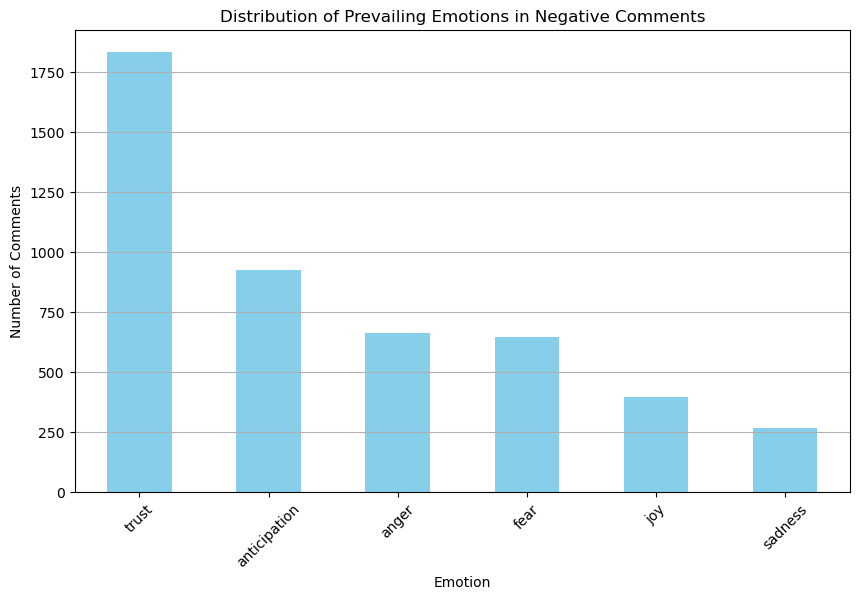

In [62]:
import matplotlib.pyplot as plt

# Function to get prevailing emotion
def prevailing_emotion(emotions):
    prevailing = {k: v for k, v in emotions.items() if v > 0.25}
    if prevailing:
        return max(prevailing, key=prevailing.get)
    return None

# Apply the function to get the prevailing emotion for each comment
negative_comments['prevailing_emotion'] = negative_comments['emotions'].apply(prevailing_emotion)

# Count the frequency of each prevailing emotion
emotion_counts = negative_comments['prevailing_emotion'].value_counts()

# Plot the emotion distribution
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Prevailing Emotions in Negative Comments')
plt.xlabel('Emotion')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


C:\Users\DELL\AppData\Local\Temp\ipykernel_22304\2495110204.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_comments['prevailing_emotion'] = negative_comments['emotions'].apply(prevailing_emotion)


<Figure size 1000x600 with 0 Axes>

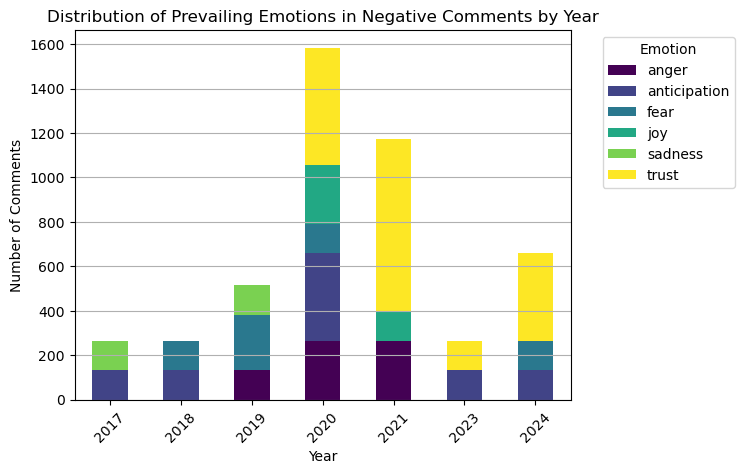

In [83]:
import matplotlib.pyplot as plt

# Function to get prevailing emotion
def prevailing_emotion(emotions):
    prevailing = {k: v for k, v in emotions.items() if v > 0.25}
    if prevailing:
        return max(prevailing, key=prevailing.get)
    return None

# Apply the function to get the prevailing emotion for each comment
negative_comments['prevailing_emotion'] = negative_comments['emotions'].apply(prevailing_emotion)

# Count the frequency of each prevailing emotion by year
emotion_counts_by_year = negative_comments.groupby(['year', 'prevailing_emotion']).size().unstack()

# Plot the emotion distribution by year
plt.figure(figsize=(10, 6))
emotion_counts_by_year.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Distribution of Prevailing Emotions in Negative Comments by Year')
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
